## 프로젝트 : This is your playground! Leaderboard를 정복해 주세요!


### 0. 루브릭

* 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
* 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
* 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?

### 튜닝해볼 수 있는 모델 클래스 인자
대표적으로 자주 튜닝하는 lightgbm 라이브러리의 인자는 다음과 같습니다.

* max_depth : 의사 결정 나무의 깊이, 정수 사용
* learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
* n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
* num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
* boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력

In [156]:
import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
import missingno as msno #Visulization
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc
import plotly.graph_objs as go
import plotly.offline as py
from plotly import tools

### 1. 데이터 살펴보기

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [157]:
train_data_path = 'C:/project/aiffel_exp/exp5_kaggle/train.csv'
sub_data_path = 'C:/project/aiffel_exp/exp5_kaggle/test.csv'

print(train_data_path)
print(sub_data_path)

C:/project/aiffel_exp/exp5_kaggle/train.csv
C:/project/aiffel_exp/exp5_kaggle/test.csv


In [158]:
df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(sub_data_path)

In [159]:
print("train.csv. Shape: ",df_train.shape)
print("test.csv. Shape: ",df_test.shape)

train.csv. Shape:  (15035, 21)
test.csv. Shape:  (6555, 20)


In [160]:
df_train.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
5,5,20150403T000000,662500.0,3,2.50,3560,9796,1.0,0,0,3,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925
6,6,20140527T000000,468000.0,2,1.00,1160,6000,1.0,0,0,4,7,860,300,1942,0,98115,47.6900,-122.292,1330,6000
7,7,20140528T000000,310000.0,3,1.00,1430,19901,1.5,0,0,4,7,1430,0,1927,0,98028,47.7558,-122.229,1780,12697
8,8,20141007T000000,400000.0,3,1.75,1370,9680,1.0,0,0,4,7,1370,0,1977,0,98074,47.6127,-122.045,1370,10208
9,9,20150312T000000,530000.0,5,2.00,1810,4850,1.5,0,0,3,7,1810,0,1900,0,98107,47.6700,-122.394,1360,4850


In [161]:
df_test.head(10)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15208,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
1,15209,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
2,15210,20150124T000000,4,3.00,2950,5000,2.0,0,3,3,9,1980,970,1979,0,98126,47.5714,-122.375,2140,4000
3,15211,20141205T000000,2,1.00,1200,9850,1.0,0,0,4,7,1200,0,1921,0,98002,47.3089,-122.210,1060,5095
4,15212,20140514T000000,4,1.75,1620,4980,1.0,0,0,4,7,860,760,1947,0,98133,47.7025,-122.341,1400,4980
5,15213,20140703T000000,5,2.50,2270,6300,2.0,0,0,3,8,2270,0,1995,0,98092,47.3266,-122.169,2240,7005
6,15214,20140624T000000,3,1.75,1520,6380,1.0,0,0,3,7,790,730,1948,0,98115,47.6950,-122.304,1520,6235
7,15215,20150302T000000,4,2.50,2570,7173,2.0,0,0,3,8,2570,0,2005,0,98052,47.7073,-122.110,2630,6026
8,15216,20140613T000000,3,2.50,2300,3060,1.5,0,0,3,8,1510,790,1930,2002,98115,47.6827,-122.310,1590,3264
9,15217,20141230T000000,4,2.00,2360,6000,2.0,0,0,4,8,2360,0,1904,0,98107,47.6702,-122.362,1730,4700


#### 1.1 결측치 확인

<AxesSubplot:>

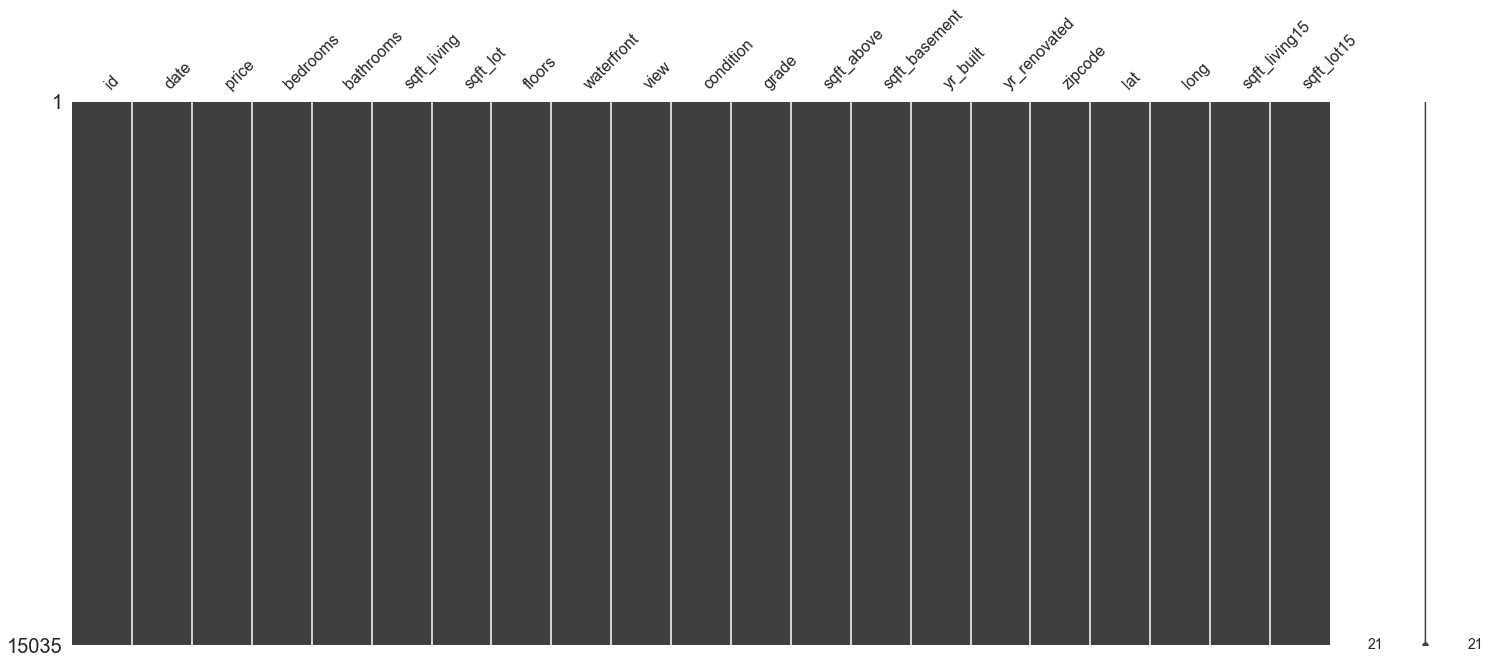

In [162]:
msno.matrix(df_train)

In [163]:
df_train.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

#### 1.2 유니크한 갯수 확인

In [164]:
### 유니크 갯수 계산
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

import plotly.graph_objs as go

import time
import random

def generate_color():
    color = '#{:02x}{:02x}{:02x}'.format(*map(lambda x: random.randint(0, 255), range(3)))
    return color

train_unique = []
columns = ['bedrooms','bathrooms','floors','waterfront','view','condition','grade']

for i in columns:
    train_unique.append(len(df_train[i].unique()))
unique_train = pd.DataFrame()
unique_train['Columns'] = columns
unique_train['Unique_value'] = train_unique

data = [
    go.Bar(
        x = unique_train['Columns'],
        y = unique_train['Unique_value'],
        name = 'Unique value in features',
        textfont=dict(size=20),
        marker=dict(
        line=dict(
            color= generate_color(),
            #width= 2,
        ), opacity = 0.45
    )
    ),
    ]
layout= go.Layout(
        title= "Unique Value By Column",
        xaxis= dict(title='Columns', ticklen=5, zeroline=False, gridwidth=2),
        yaxis= dict(title='Value Count', ticklen=5, gridwidth=2),
        showlegend=True
    )
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='skin')

waterfront는 2개로 있다or없다고 구분하는듯 하고 view와 condition은 등급을 나타내는 것으로 보인다.

#### 1.3 목적변수 확인

In [165]:
#descriptive statistics summary
df_train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

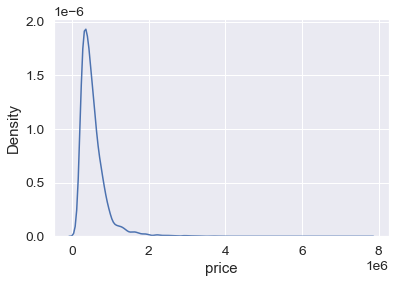

In [166]:
# prict 분포 확인
sns.kdeplot(df_train['price'])
plt.show()

<AxesSubplot:xlabel='price', ylabel='Density'>

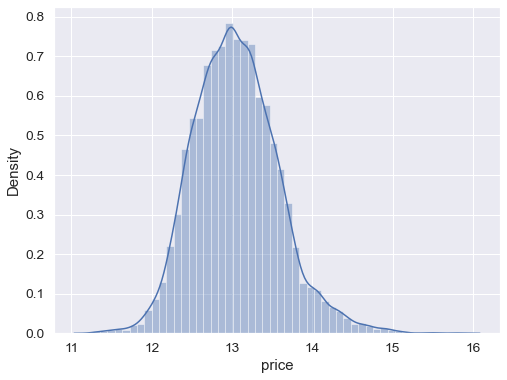

In [167]:
# 정규화
df_train['price'] = np.log1p(df_train['price'])
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_train['price'])

#### 1.4 반응변수 시각화

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

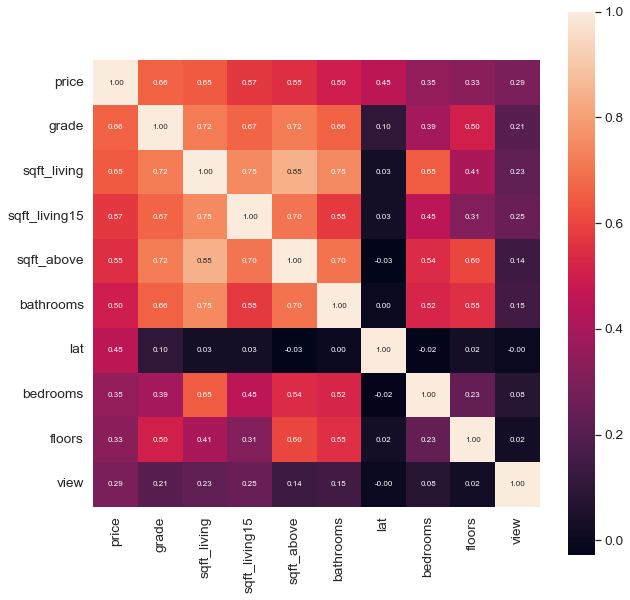

In [168]:
# correlation이 높은 상위 10개의 heatmap
# continuous + sequential variables --> spearman
# abs는 반비례관계도 고려하기 위함
# https://www.kaggle.com/junoindatascience/let-s-eda-it 준호님이 수정해 준 코드로 사용하였습니다. 
import scipy as sp

cor_abs = abs(df_train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(df_train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

price와 상관도가 높은 변수는 grade, sqft_living, sqft_above, lat 순서

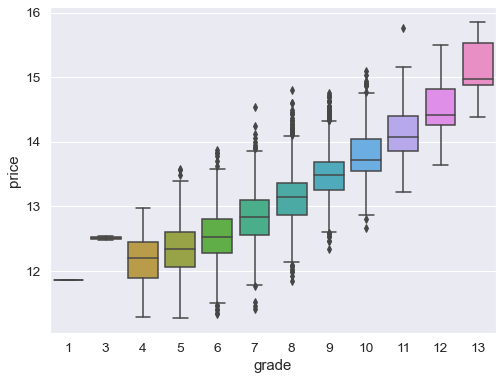

In [169]:
# grade 분포 확인
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

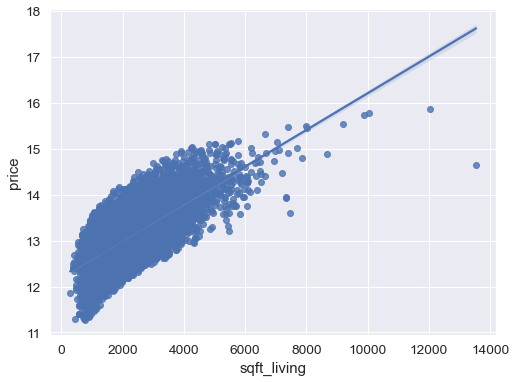

In [170]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

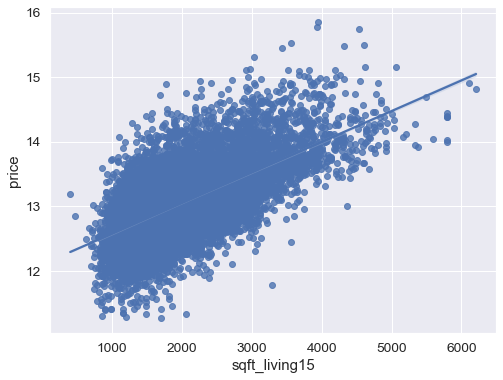

In [171]:
data = pd.concat([df_train['price'], df_train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=data)

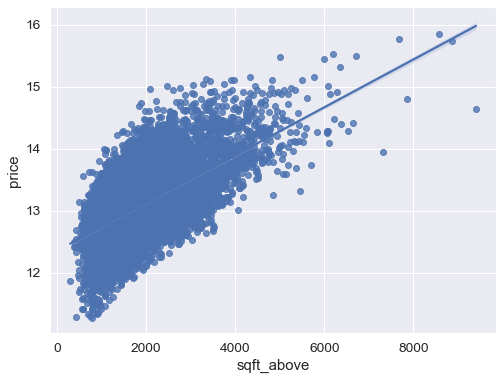

In [172]:
data = pd.concat([df_train['price'], df_train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y="price", data=data)

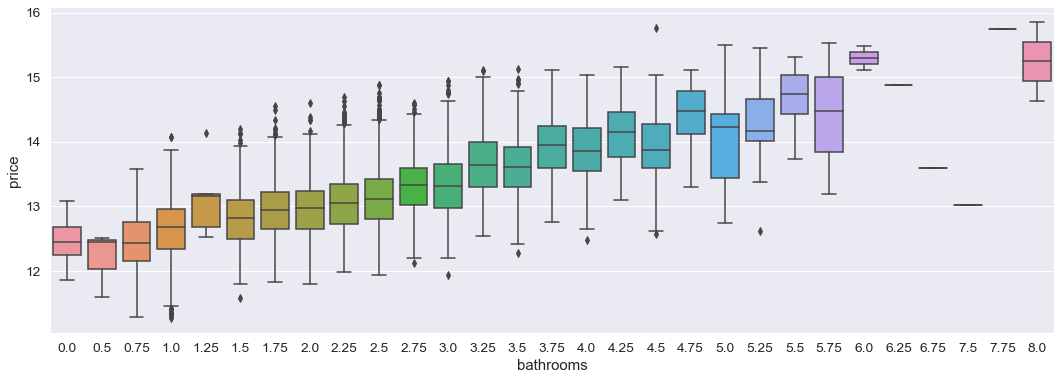

In [173]:
data = pd.concat([df_train['price'], df_train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=data)

### 2. 데이터 전처리

#### 2.1 이상치 제거

##### 2.1.1sqft_living

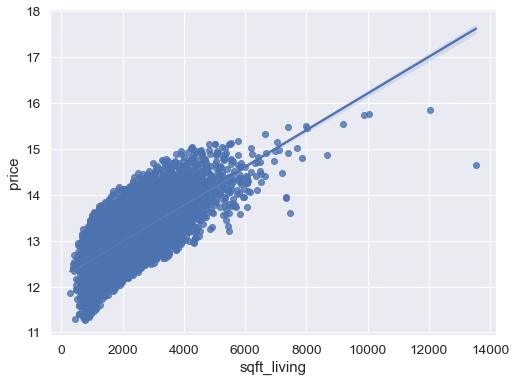

In [174]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [175]:
df_train.loc[df_train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [176]:
df_train = df_train.loc[df_train['id']!=8990]

##### 2.1.2 grade

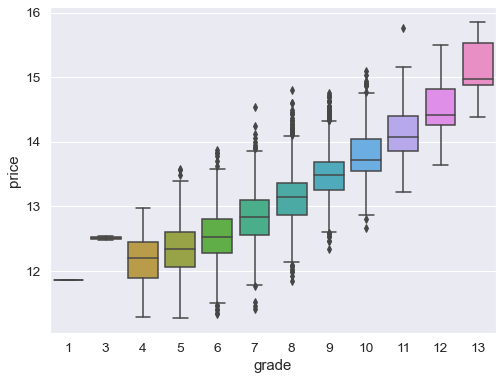

In [177]:
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

In [178]:
df_train.loc[(df_train['price']>12) & (df_train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,5,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,2,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [179]:
df_train.loc[(df_train['price']>14.7) & (df_train['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,20140813T000000,14.808763,5,4.0,4230,27295,2.0,1,4,3,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [180]:
df_train.loc[(df_train['price']>15.5) & (df_train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


In [181]:
df_train = df_train.loc[df_train['id']!=456]
df_train = df_train.loc[df_train['id']!=2302]
df_train = df_train.loc[df_train['id']!=4123]
df_train = df_train.loc[df_train['id']!=7259]
df_train = df_train.loc[df_train['id']!=2777]

##### 2.1.3 badroom

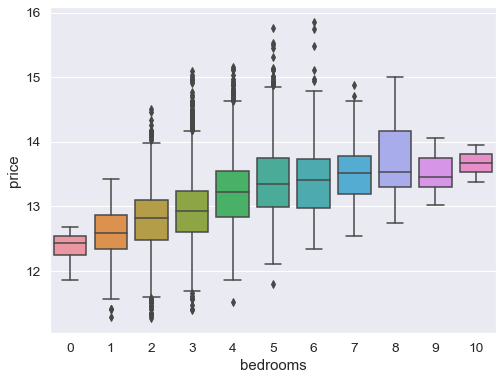

In [182]:
data = pd.concat([df_train['price'], df_train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

In [183]:
# 정규화
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    df_train[c] = np.log1p(df_train[c].values)
    df_test[c] = np.log1p(df_test[c].values)

In [184]:
for df in [df_train,df_test]:
    df['date'] = df['date'].apply(lambda x: x[0:8])
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

In [ ]:
변수 생성

In [185]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,1955.0,98178,47.5112,-122.257,1340,5650
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,1987.0,98074,47.6168,-122.045,1800,7503
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,1995.0,98003,47.3097,-122.327,2238,6819
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,1963.0,98198,47.4095,-122.315,1650,9711


In [187]:
for df in [df_train,df_test]:
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율 : 15로 수정
    df['sqft_ratio'] = df['sqft_living15'] / df['sqft_lot15']
    
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 면적 대비 거실의 비율 : 15로 수정
    df['sqft_ratio_1'] = df['sqft_living15'] / df['sqft_total_size']
    
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['date'] = df['date'].astype('int')

In [188]:
# 평당 가격
df_train['per_price'] = df_train['price']/df_train['sqft_total_size']
zipcode_price = df_train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
df_train = pd.merge(df_train,zipcode_price,how='left',on='zipcode')
df_test = pd.merge(df_test,zipcode_price,how='left',on='zipcode')

for df in [df_train,df_test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean']; del df['var']

### 3. 모델링

In [191]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import RidgeCV

train_columns = [c for c in df_train.columns if c not in ['id','price','per_price']]

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

y_reg = df_train['price']

#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][train_columns], label=y_reg.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][train_columns], label=y_reg.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(df_test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, y_reg))
print(cv)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.14036	valid_1's rmse: 0.156367
[1000]	training's rmse: 0.121366	valid_1's rmse: 0.152862
[1500]	training's rmse: 0.108733	valid_1's rmse: 0.152004
Early stopping, best iteration is:
[1591]	training's rmse: 0.106785	valid_1's rmse: 0.151954
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.13958	valid_1's rmse: 0.159972
[1000]	training's rmse: 0.121089	valid_1's rmse: 0.155988
[1500]	training's rmse: 0.108392	valid_1's rmse: 0.15496
[2000]	training's rmse: 0.0984237	valid_1's rmse: 0.154592
Early stopping, best iteration is:
[2084]	training's rmse: 0.0969526	valid_1's rmse: 0.154573
[LightGBM] [Warning] min_data_in_leaf is se

In [192]:
cv1 = np.sqrt(mean_squared_error(np.expm1(oof), np.expm1(y_reg)))
print(cv1)

115625.78472900216


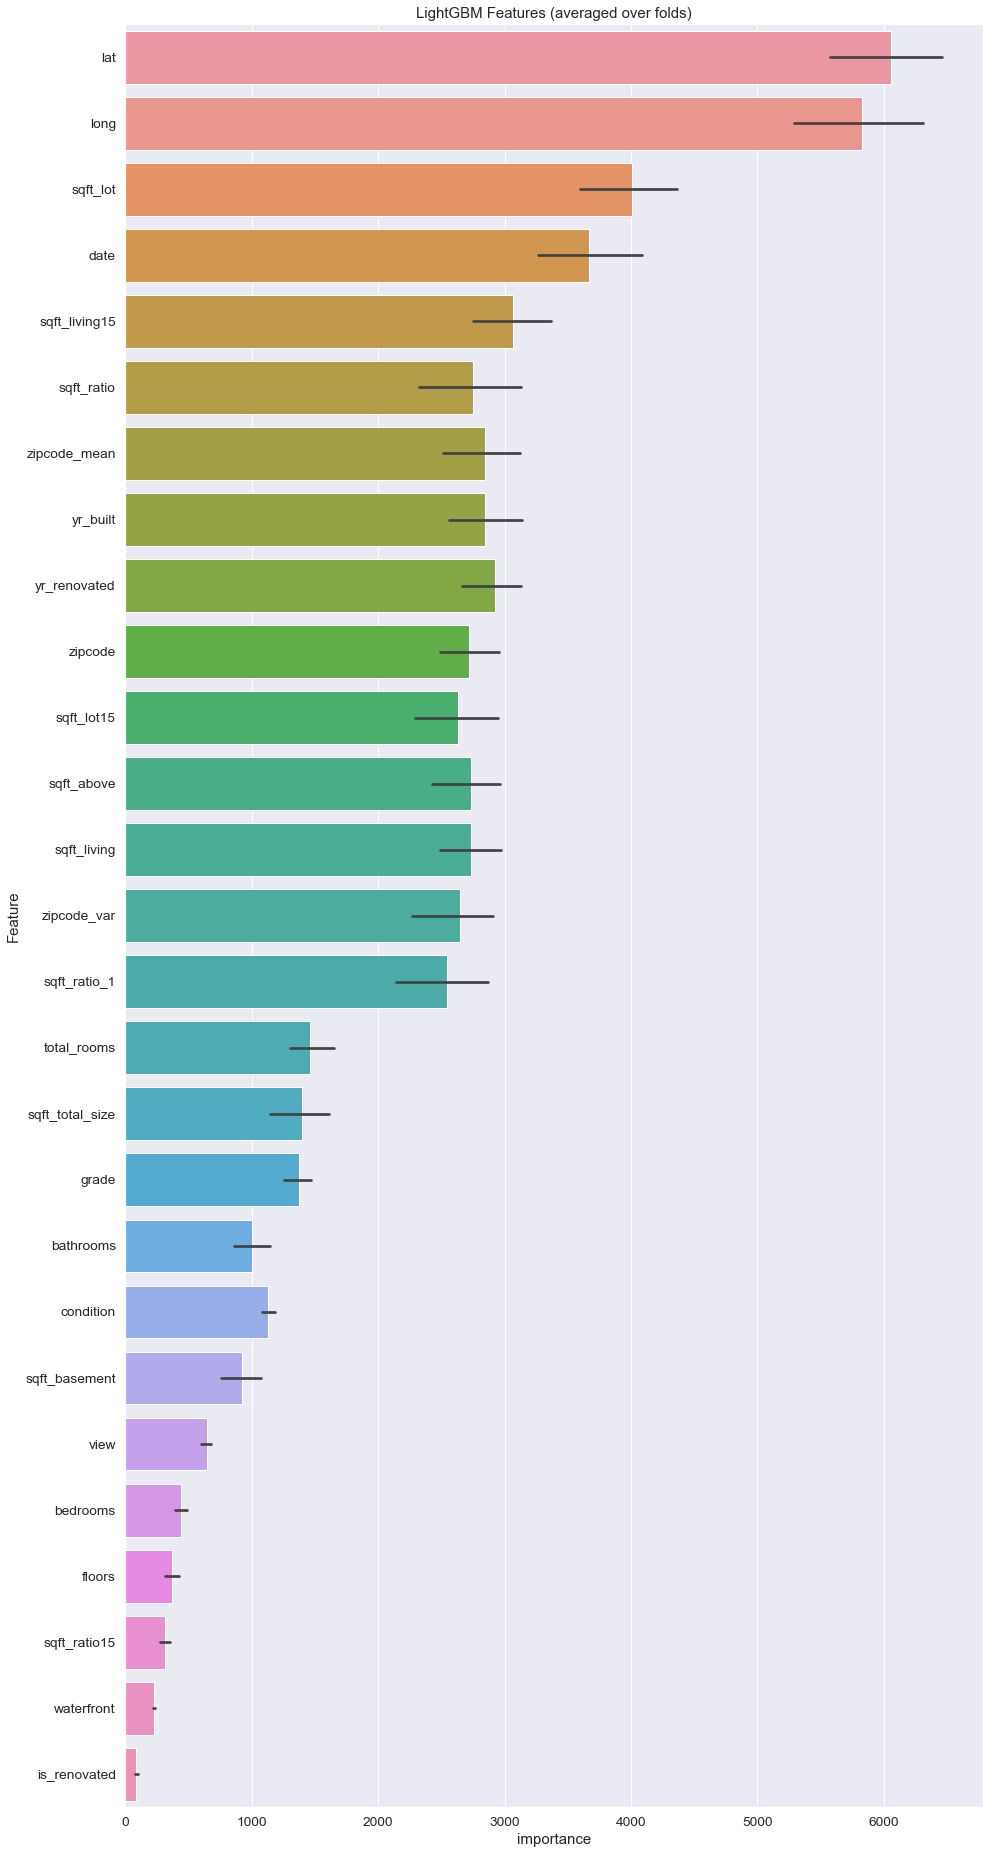

In [193]:
##plot the feature importance
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

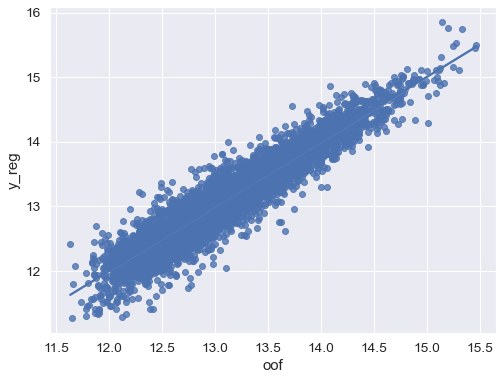

In [194]:
df_oof = pd.DataFrame(oof)
df_y_reg = pd.DataFrame(y_reg)

data = pd.concat([df_oof, df_y_reg], axis=1)
data.columns = ['oof','y_reg']
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='oof', y="y_reg", data=data)

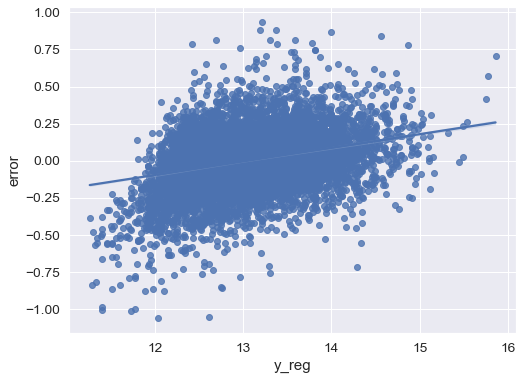

In [195]:
data = pd.concat([df_oof, df_y_reg], axis=1)
data.columns = ['oof','y_reg']
data['error'] = data['y_reg'] - data['oof']
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='y_reg', y="error", data=data)

#### 3.1 Ensemble

In [196]:
lgb1_oof = pd.DataFrame()
lgb1_oof['id'] = df_train.id
lgb1_oof['price'] = oof

lgb1_sub = pd.DataFrame()
lgb1_sub['id'] = df_test.id
lgb1_sub['price'] = predictions

cv1 = np.sqrt(mean_squared_error(np.expm1(oof), np.expm1(y_reg)))
print(cv1)

115625.78472900216


In [197]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import RidgeCV

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

y_reg = np.expm1(df_train['price'])

#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][train_columns], label=y_reg.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][train_columns], label=y_reg.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(df_test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, y_reg))
print(cv)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 135573	valid_1's rmse: 134875
[1000]	training's rmse: 110732	valid_1's rmse: 123594
[1500]	training's rmse: 99627.2	valid_1's rmse: 121370
[2000]	training's rmse: 91447.8	valid_1's rmse: 120815
Early stopping, best iteration is:
[2066]	training's rmse: 90546.8	valid_1's rmse: 120700
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 135101	valid_1's rmse: 134583
[1000]	training's rmse: 110552	valid_1's rmse: 117135
[1500]	training's rmse: 100200	valid_1's rmse: 114411
[2000]	training's rmse: 92385.6	valid_1's rmse: 114037
Early stopping, best iteration is:
[1913]	training's rmse: 93592.6	valid_1's rmse: 113979
[LightGBM] [Warning

In [198]:
lgb2_oof = pd.DataFrame()
lgb2_oof['id'] = df_train.id
lgb2_oof['price'] = oof

lgb2_sub = pd.DataFrame()
lgb2_sub['id'] = df_test.id
lgb2_sub['price'] = predictions

cv2 = np.sqrt(mean_squared_error(oof, y_reg))
print(cv2)

124428.42711261995


In [199]:
# code : https://www.kaggle.com/karell/kakr-2nd-house-price-xgb-starter-109145
import xgboost as xgb

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

log_y_reg = np.log1p(y_reg)
print('Transform DMatrix...')
dtrain = xgb.DMatrix(df_train[train_columns], log_y_reg)
dtest = xgb.DMatrix(df_test[train_columns])

print('Start Cross Validation...')

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=5000, early_stopping_rounds=50,verbose_eval=500, show_stdv=False)
print('best num_boost_rounds = ', len(cv_output))
rounds = len(cv_output)

model = xgb.train(xgb_params, dtrain, num_boost_round = rounds)
preds = model.predict(dtest)

xgb1_sub = df_test[['id']]
xgb1_sub['price'] = preds

Transform DMatrix...
Start Cross Validation...
[05:00:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[05:00:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:00:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[05:00:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with s

In [200]:
# code : https://www.kaggle.com/karell/kakr-2nd-house-price-xgb-starter-109145
import xgboost as xgb

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

print('Transform DMatrix...')
dtrain = xgb.DMatrix(df_train[train_columns], y_reg)
dtest = xgb.DMatrix(df_test[train_columns])

print('Start Cross Validation...')

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=20000, early_stopping_rounds=50,verbose_eval=500, show_stdv=False)
print('best num_boost_rounds = ', len(cv_output))
rounds = len(cv_output)

model = xgb.train(xgb_params, dtrain, num_boost_round = rounds)
preds = model.predict(dtest)

xgb2_sub = df_test[['id']]
xgb2_sub['price'] = preds

Transform DMatrix...
Start Cross Validation...
[05:02:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[05:02:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:02:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[05:02:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with s

In [201]:
lgb_oof = pd.merge(lgb1_oof,lgb2_oof,how='left',on='id')
lgb_train = df_train[['id','price']]
lgb_oof = pd.merge(lgb_oof,lgb_train,how='left',on='id')
lgb_oof.columns = ['id','price1','price2','price']

lgb_ensemble = (0.9*np.expm1(lgb_oof['price1']) + 0.1*lgb_oof['price2']).values
cv = np.sqrt(mean_squared_error(lgb_ensemble, np.expm1(lgb_oof['price']).values))
print(cv)

115460.9910953515


In [202]:
lgb_sub = pd.merge(lgb1_sub,lgb2_sub,how='left',on='id')
lgb_sub.columns = ['id','price1','price2']
lgb_sub['price'] = (0.9*np.expm1(lgb_sub['price1']) + 0.1*lgb_sub['price2'])
lgb_sub = lgb_sub[['id','price']]

In [203]:
xgb_sub = pd.merge(xgb1_sub,xgb2_sub,how='left',on='id')
xgb_sub.columns = ['id','price1','price2']
xgb_sub['price'] = (0.9*np.expm1(xgb_sub['price1']) + 0.1*xgb_sub['price2'])
xgb_sub = xgb_sub[['id','price']]

In [208]:
ensemble_sub = pd.merge(lgb_sub,xgb_sub,how='left',on='id')
ensemble_sub.columns = ['id','price1','price2']
ensemble_sub['price'] = 0.9*ensemble_sub['price1'] + 0.1*ensemble_sub['price2']
ensemble_sub = ensemble_sub[['id','price']]

submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format('C:/project/aiffel_exp/exp5_kaggle', 'lgbm', '0.164399')
ensemble_sub.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

C:/project/aiffel_exp/exp5_kaggle/submission_lgbm_RMSLE_0.164399.csv


### 4. 느낀점

1. 데이터를 살펴보고 그 안에서 정보를 얻고 방향성을 고민하는 과정이 중요함을 크게 느낀 exp 였다.
2. 변수들 간의 상관관계를 파악하고 변수를 줄이거나, 변수들끼리 합치는 과정을 직접 읽고 시도해보는 점이 흥미로웠다.
3. 여러모로 아쉬운 exp였다. 어쩌다보니 exp의 우선순위가 밀리고 밀려 시간이 너무 부족했고, 결국 과제는 엉망진창이 되었다. exp를 진행하는 시간은 즐거웠으나 일정 관리에 실패하여 과정과 결과물 전부 아쉬움이 크게 남는다.